In [1]:
import numpy as np 
import chaospy as cp 
import copy
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

### Ishigami Function and Models
$$f(Z) = \sin(Z_{1}) + a\sin^2 (Z_{2}) + b Z_{3}^{4} \sin(Z_{1}), \qquad Z_{i} \sim U(-\pi, \pi). $$


The ANOVA-HDMR unique decomposition of this function is $f(Z) = f_{0} + f_{1}(Z_{1}) + f_{2}(Z_{2}) + f_{13}(Z_{1}, Z_{3})$ with 

$$f_{0} = \frac{a}{2},\\ 
f_{1}(Z_{1}) = \left(1 + b \frac{\pi^4}{5}\right) \sin(Z_{1}),\\
f_{2}(Z_{2}) = a \sin^2(Z_{2}) - \frac{a}{2},\\
f_{1,3}(Z_{1}, Z_{3}) = b \sin(Z_{1}) \left(Z_{3}^4 - \frac{\pi^4}{5}\right),
$$
such that 
$$
\int_{\mathbb{R}} f_{u}(z_{u}) \rho_{u}(z_{u}) \mathrm{d} z_{u} = 0, \qquad \forall u \in \{1, 2, \{1,3\}\}
$$
where $\rho_{u}$ is the density of the random variable $Z$ with index $u$. The expectation of $f(Z)$ can be computed analytically, such that
$$
\mathbb{E}[f(Z)] = \mathbb{E}[f_{0} + f_{1}(Z_{1}) + f_{2}(Z_{2}) + f_{1,3}(Z_{1}, Z_{3})] = \mathbb{E}[f_{0}] + \mathbb{E}[f_{1}(Z_{1})] + \mathbb{E}[f_{2}(Z_{2})] + \mathbb{E}[f_{1,3}(Z_{1}, Z_{3})] = \frac{a}{2}.
$$
Similarly, the variance of $f(Z)$ is
$$
\text{Var}[f(Z)] = \frac{1}{8\pi^3} \int_{-\pi}^{\pi}  \int_{-\pi}^{\pi}   \int_{-\pi}^{\pi} \left(f(Z) - \mathbb{E}[f(z)]\right)^2 \mathrm{d}z_{1} \mathrm{d} z_{2} \mathrm{d} z_{3} = \frac{1}{2} + \frac{a^2}{8} + \frac{\pi^4 b}{5} + \frac{\pi^8 b^2}{18}.
$$
The component variances are 
$$
V_{1} = \text{Var}[f_{1}(Z_{1})] = \frac{1}{2\pi}\int_{-\pi}^{\pi} \left(1 + b\frac{\pi^4}{5}\right)^2 \sin^2(z_{1}) \mathrm{d}z_{1} = \frac{1}{2}\left( 1+ b \frac{\pi^4}{5}\right)^2,\\
V_{2} = \text{Var}[f_{2}(Z_{2})] = \frac{1}{2\pi}  \int_{-\pi}^{\pi} a^2 \left( \sin^2(z_{2}) - \frac{1}{2}\right)^2 \mathrm{d} z_{2} = \frac{a^2}{8},\\
V_{1,3} = \text{Var}[f_{1,3}(Z_{1}, Z_{3})] = \frac{1}{4\pi^2}\int_{-\pi}^{\pi} \int_{-\pi}^{\pi} b^2 \sin^2(z_{1}) \left(z_{3}^4 - \frac{\pi^4}{5}\right)^2 \mathrm{d}z_{1} \mathrm{d}z_{3} =  \pi^8 b^2 \left( \frac{1}{18} - \frac{1}{50}\right).
$$


### References
[1] E. Qian, B. Peherstorfer, D. O’Malley, V. V. Vesselinov, and K. Willcox. Multifidelity monte carlo estimation of variance and sensitivity indices. SIAM/ASA Journal on Uncertainty Quantification, 6(2):683–706, 2018

In [2]:
def f_fun(z1, z2, z3, a, b):
    return np.sin(z1) + a * (np.sin(z2)**2) + b* np.sin(z1) * (z3**4)

def V1_analytic(b):
    return 0.5 * (1 + 1/5 * b * np.pi**4)**2

def V2_analytic(a):
    return (a**2) / 8 

def V13_analytic(b):
    return np.pi**8 * b**2 * (1/18 - 1/50)

def Vt_analytic(a, b):
    return 0.5 + 1/8 * a**2 + 1/5 * np.pi**4 * b + 1/18 * b**2 * np.pi**8 

In [3]:
# set up parameters (deterministic)
a, b = 5, 0.1

# print Sobol indices
print("S1 = ", V1_analytic(b)/ Vt_analytic(a, b))
print("S2 = ", V2_analytic(a)/ Vt_analytic(a, b))
print("S13 = ", V13_analytic(b)/ Vt_analytic(a, b))

S1 =  0.40074256833459065
S2 =  0.28816217057600235
S13 =  0.3110952610894071


The above agrees with the results presented in [1]. 

### Monte-Carlo computation of Sobol indices using HDMR

### Step 1: 
Draw $2N$ samples of $Z_{i} \sim \rho_{i}$ and store in matrices $A$ and $B$.

In [4]:
np.random.seed(seed=0)

N = 10**5

z1_samples = np.random.uniform(low=-np.pi, high=np.pi, size=2*N)
z2_samples = np.random.uniform(low=-np.pi, high=np.pi, size=2*N)
z3_samples = np.random.uniform(low=-np.pi, high=np.pi, size=2*N)

In [5]:
A, B = np.zeros((N, 3)), np.zeros((N, 3))
A[:, 0] = z1_samples[:N]
A[:, 1] = z2_samples[:N]
A[:, 2] = z3_samples[:N]

B[:, 0] = z1_samples[N:]
B[:, 1] = z2_samples[N:]
B[:, 2] = z3_samples[N:]

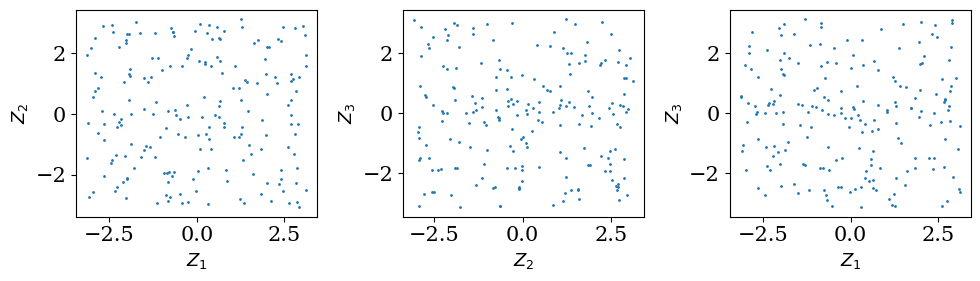

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
ax[0].scatter(z1_samples[::1000], z2_samples[::1000], s=1)
ax[0].set_xlabel("$Z_{1}$")
ax[0].set_ylabel("$Z_{2}$")

ax[1].scatter(z2_samples[::1000], z3_samples[::1000], s=1)
ax[1].set_xlabel("$Z_{2}$")
ax[1].set_ylabel("$Z_{3}$")

ax[2].scatter(z1_samples[::1000], z3_samples[::1000], s=1)
ax[2].set_xlabel("$Z_{1}$")
ax[2].set_ylabel("$Z_{3}$")
plt.tight_layout()

### Step 2:
Define the new matrix $C^{(i)}$ which is all of $B$ except the $i$th column is replaced by the $i$th column of $A$ so that 


In [21]:
C1, C2, C3 = copy.deepcopy(B), copy.deepcopy(B), copy.deepcopy(B)

In [22]:
C1[:, 0] = A[:, 0]
C2[:, 1] = A[:, 1]
C3[:, 2] = A[:, 2]

### Step 3:
Use the model $Y = f(Z_{1}, Z_{2}, Z_{3})$ to compute the output $Y$ from each of the matricies, i.e. 

In [23]:
YA = f_fun(z1=A[:, 0], z2=A[:, 1], z3=A[:, 2], a=a, b=b) 
YB = f_fun(z1=B[:, 0], z2=B[:, 1], z3=B[:, 2], a=a, b=b) 
YC1 = f_fun(z1=C1[:, 0], z2=C1[:, 1], z3=C1[:, 2], a=a, b=b) 
YC2 = f_fun(z1=C2[:, 0], z2=C2[:, 1], z3=C2[:, 2], a=a, b=b) 
YC3 = f_fun(z1=C3[:, 0], z2=C3[:, 1], z3=C3[:, 2], a=a, b=b) 

### Step 4:
The main effect and total effect sensitivity are 
$$
S_{i} = \frac{\frac{1}{N} y_{A}^{\top}y_{C^{(i)}} - f_{0}^2}{\frac{1}{N} y_{A}^{\top} y_{A} - f_{0}^2}
$$
and the total effect is 
$$
S^{total}_{i} = 1 - \frac{\frac{1}{N} y_{B}^{\top}y_{C^{(i)}} - f_{0}^2}{\frac{1}{N} y_{A}^{\top} y_{A} - f_{0}^2}
$$
with 
$f_{0} = \mathbb{E}[Y] \approx \frac{1}{N} \sum_{j=1}^{N} y_{A}^{(j)}$.

In [80]:
f0 = np.mean(YA)

# main or first sobol indices
S1 = (1/N * YA.T @ YC1 - f0**2)/(1/N * YA.T @ YA - f0**2)
S2 = (1/N * YA.T @ YC2 - f0**2)/(1/N * YA.T @ YA - f0**2)
S3 = (1/N * YA.T @ YC3 - f0**2)/(1/N * YA.T @ YA - f0**2)

# total effect sobal indices
S1_total = 1 - (1/N * YB.T @ YC1 - f0**2)/(1/N * YA.T @ YA - f0**2)
S2_total = 1 - (1/N * YB.T @ YC2 - f0**2)/(1/N * YA.T @ YA - f0**2)
S3_total = 1 - (1/N * YB.T @ YC3 - f0**2)/(1/N * YA.T @ YA - f0**2)

In [81]:
print("MC estimate of S1", S1)
print("(True) S1 = ", V1_analytic(b=b)/ Vt_analytic(a=a, b=b))

MC estimate of S1 0.39652921023590715
(True) S1 =  0.40074256833459065


In [82]:
print("MC estimate of S2 = ", S2)
print("(True) S2 = ", V2_analytic(a=a)/ Vt_analytic(a=a, b=b))

MC estimate of S2 =  0.29813763755198125
(True) S2 =  0.28816217057600235


In [83]:
print("MC estimate of S3 = ", S3)
print("(True) S3 = ", 0)

MC estimate of S3 =  0.003250881652518133
(True) S3 =  0


In [84]:
print("MC estimate of S1 total", S1_total)
print("(True) S1 = ", (V1_analytic(b=b) + V13_analytic(b=b))/ Vt_analytic(a=a, b=b))

MC estimate of S1 total 0.7075565020847414
(True) S1 =  0.7118378294239978


In [85]:
print("MC estimate of S2 total", S2_total)
print("(True) S2 = ", (V2_analytic(a=a))/ Vt_analytic(a=a, b=b))

MC estimate of S2 total 0.27211579143006825
(True) S2 =  0.28816217057600235


In [86]:
print("MC estimate of S3 total", S3_total)
print("(True) S3 = ", (V13_analytic(b=b))/ Vt_analytic(a=a, b=b))

MC estimate of S3 total 0.30205330023688737
(True) S3 =  0.3110952610894071


#### Repeat the analysis to ensure converge "law of large numbers"

In [88]:
N_vec = 10**np.arange(1, 9)

In [91]:
S_res, S_tot_res = np.zeros((3, len(N_vec))), np.zeros((3, len(N_vec)))

In [99]:
jj = 0
for N in N_vec:
    # number of samples
    N = int(N)

    # step 1
    A, B = np.zeros((N, 3)), np.zeros((N, 3))
    A[:, 0] = np.random.uniform(low=-np.pi, high=np.pi, size=N)
    A[:, 1] = np.random.uniform(low=-np.pi, high=np.pi, size=N)
    A[:, 2] = np.random.uniform(low=-np.pi, high=np.pi, size=N)

    B[:, 0] = np.random.uniform(low=-np.pi, high=np.pi, size=N)
    B[:, 1] = np.random.uniform(low=-np.pi, high=np.pi, size=N)
    B[:, 2] = np.random.uniform(low=-np.pi, high=np.pi, size=N)
    
    # step 2
    C1, C2, C3 = copy.deepcopy(B), copy.deepcopy(B), copy.deepcopy(B)
    C1[:, 0] = A[:, 0]
    C2[:, 1] = A[:, 1]
    C3[:, 2] = A[:, 2]
    
    # step 3
    YA = f_fun(z1=A[:, 0], z2=A[:, 1], z3=A[:, 2], a=a, b=b) 
    YB = f_fun(z1=B[:, 0], z2=B[:, 1], z3=B[:, 2], a=a, b=b) 
    YC1 = f_fun(z1=C1[:, 0], z2=C1[:, 1], z3=C1[:, 2], a=a, b=b) 
    YC2 = f_fun(z1=C2[:, 0], z2=C2[:, 1], z3=C2[:, 2], a=a, b=b) 
    YC3 = f_fun(z1=C3[:, 0], z2=C3[:, 1], z3=C3[:, 2], a=a, b=b) 
    
    # step 4
    f0 = np.mean(YA)

    # main or first sobol indices
    S_res[0, jj] = (1/N * YA.T @ YC1 - f0**2)/(1/N * YA.T @ YA - f0**2)
    S_res[1, jj] = (1/N * YA.T @ YC2 - f0**2)/(1/N * YA.T @ YA - f0**2)
    S_res[2, jj] = (1/N * YA.T @ YC3 - f0**2)/(1/N * YA.T @ YA - f0**2)

    # total effect sobal indices
    S_tot_res[0, jj] = 1 - (1/N * YB.T @ YC1 - f0**2)/(1/N * YA.T @ YA - f0**2)
    S_tot_res[1, jj] = 1 - (1/N * YB.T @ YC2 - f0**2)/(1/N * YA.T @ YA - f0**2)
    S_tot_res[2, jj] = 1 - (1/N * YB.T @ YC3 - f0**2)/(1/N * YA.T @ YA - f0**2)
    
    # update jj index
    jj +=1

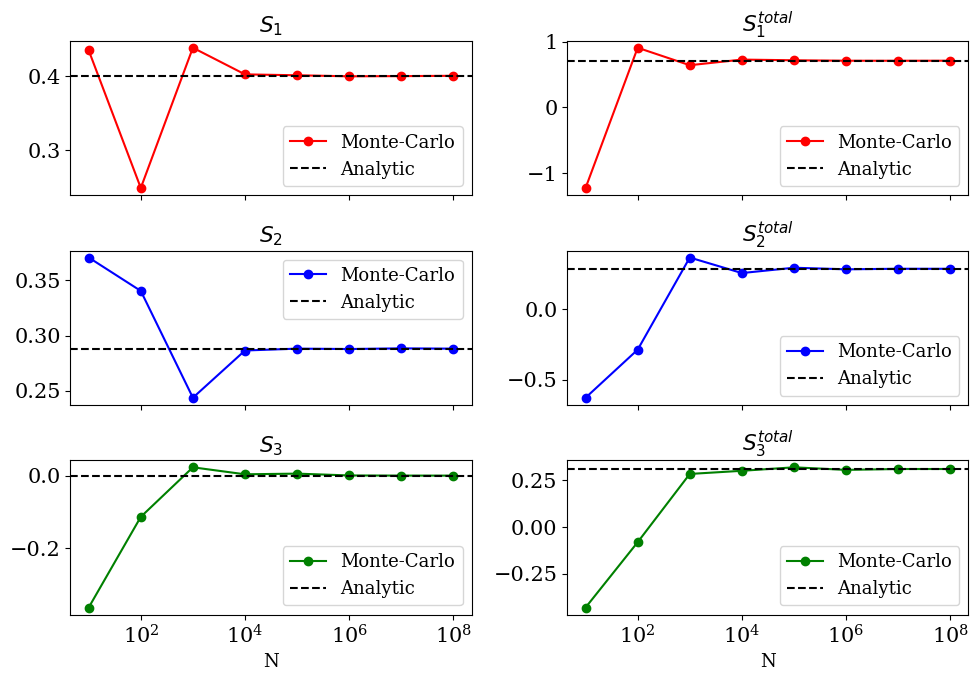

In [164]:
fig, ax = plt.subplots(ncols=2,nrows=3, sharex=True, figsize=(10, 7))
ax[0, 0].plot(N_vec, S_res[0, :], "-o", c="r", label="Monte-Carlo")
ax[1, 0].plot(N_vec, S_res[1, :], "-o", c="b", label="Monte-Carlo")
ax[2, 0].plot(N_vec, S_res[2, :], "-o", c="g", label="Monte-Carlo")
ax[0, 0].axhline(V1_analytic(b=b)/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[1, 0].axhline(V2_analytic(a=a)/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[2, 0].axhline(0, c="k", ls="--", label="Analytic")

ax[0, 0].set_xscale("log")
ax[1, 0].set_xscale("log")
ax[2, 0].set_xscale("log")

ax[0, 0].legend()
ax[1, 0].legend()
ax[2, 0].legend()

ax[0, 0].set_title("$S_{1}$")
ax[1, 0].set_title("$S_{2}$")
ax[2, 0].set_title("$S_{3}$")

ax[0, 1].plot(N_vec, S_tot_res[0, :], "-o", c="r", label="Monte-Carlo")
ax[1, 1].plot(N_vec, S_tot_res[1, :], "-o", c="b", label="Monte-Carlo")
ax[2, 1].plot(N_vec, S_tot_res[2, :], "-o", c="g", label="Monte-Carlo")
ax[0, 1].axhline((V1_analytic(b=b) + V13_analytic(b=b))/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[1, 1].axhline(V2_analytic(a=a)/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[2, 1].axhline((V13_analytic(b=b))/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")

ax[0, 1].set_title("$S^{total}_{1}$")
ax[1, 1].set_title("$S^{total}_{2}$")
ax[2, 1].set_title("$S^{total}_{3}$")

ax[0, 1].set_xscale("log")
ax[1, 1].set_xscale("log")
ax[2, 1].set_xscale("log")

ax[0, 1].legend()
ax[1, 1].legend()
ax[2, 1].legend()

ax[2,0].set_xlabel("N")
ax[2,1].set_xlabel("N")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(ncols=2,nrows=3, sharex=True, figsize=(10, 7))
ax[0, 0].plot(N_vec, (S_res[0, :], "-o", c="r", label="Monte-Carlo")
ax[1, 0].plot(N_vec, S_res[1, :], "-o", c="b", label="Monte-Carlo")
ax[2, 0].plot(N_vec, S_res[2, :], "-o", c="g", label="Monte-Carlo")
ax[0, 0].axhline(V1_analytic(b=b)/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[1, 0].axhline(V2_analytic(a=a)/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[2, 0].axhline(0, c="k", ls="--", label="Analytic")

ax[0, 0].set_xscale("log")
ax[1, 0].set_xscale("log")
ax[2, 0].set_xscale("log")

ax[0, 0].legend()
ax[1, 0].legend()
ax[2, 0].legend()

ax[0, 0].set_title("$S_{1}$")
ax[1, 0].set_title("$S_{2}$")
ax[2, 0].set_title("$S_{3}$")

ax[0, 1].plot(N_vec, S_tot_res[0, :], "-o", c="r", label="Monte-Carlo")
ax[1, 1].plot(N_vec, S_tot_res[1, :], "-o", c="b", label="Monte-Carlo")
ax[2, 1].plot(N_vec, S_tot_res[2, :], "-o", c="g", label="Monte-Carlo")
ax[0, 1].axhline((V1_analytic(b=b) + V13_analytic(b=b))/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[1, 1].axhline(V2_analytic(a=a)/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[2, 1].axhline((V13_analytic(b=b))/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")

ax[0, 1].set_title("$S^{total}_{1}$")
ax[1, 1].set_title("$S^{total}_{2}$")
ax[2, 1].set_title("$S^{total}_{3}$")

ax[0, 1].set_xscale("log")
ax[1, 1].set_xscale("log")
ax[2, 1].set_xscale("log")

ax[0, 1].legend()
ax[1, 1].legend()
ax[2, 1].legend()

ax[2,0].set_xlabel("N")
ax[2,1].set_xlabel("N")

plt.tight_layout()

### Multifidelity Monte-Carlo (MFMC) computation of Sobol indices using HDMR